# Designing Network Design Spaces
# https://arxiv.org/pdf/2003.13678

Loading CIFAR-10...


100%|██████████| 170M/170M [03:37<00:00, 785kB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torchinfo not available (optional).

Stage widths: [32, 80, 192, 496] | Stage depths: [1, 2, 5, 8]

Training...
Epoch 1/5 | Loss: 1.9134 | Acc: 32.21%
Epoch 2/5 | Loss: 1.5167 | Acc: 45.99%
Epoch 3/5 | Loss: 1.3544 | Acc: 51.67%
Epoch 4/5 | Loss: 1.2128 | Acc: 56.99%
Epoch 5/5 | Loss: 1.1288 | Acc: 60.40%

Test Accuracy: 59.12%


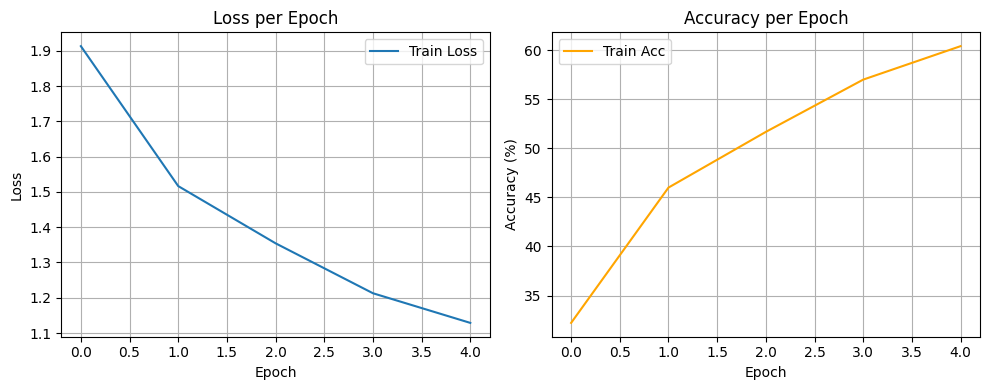

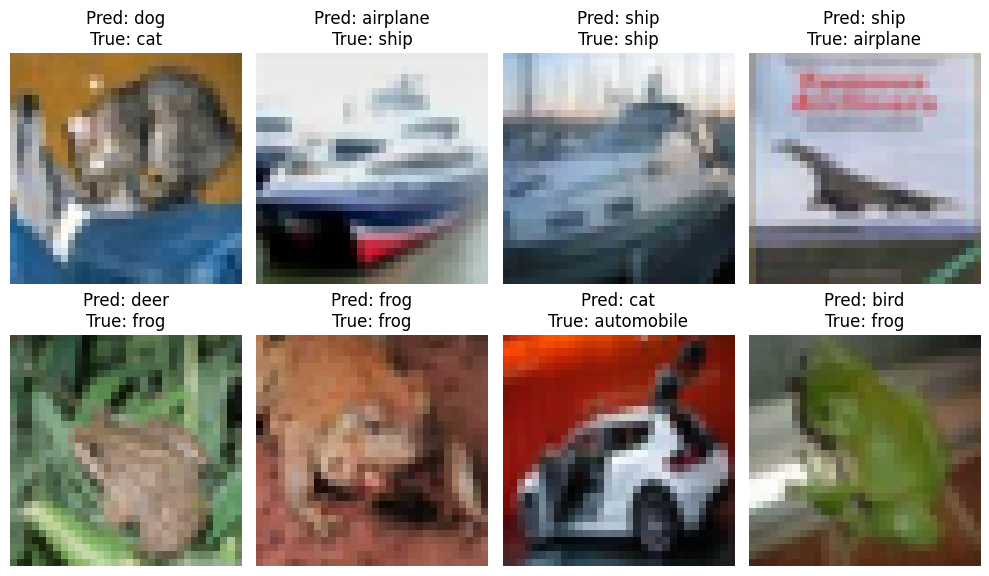

In [1]:
# ----------------------------------------------------------
# Mini-RegNet: A Didactic Replication of
# "Designing Network Design Spaces" (Radosavovic et al., 2020)
# ----------------------------------------------------------
# Implements the RegNet design-space ideas for education:
# - Quantized linear widths: u_j = w0 + wa*j, quantized by wm
# - Convert per-block widths to 4 stages (widths & depths)
# - X-blocks: 1x1 -> 3x3 group conv -> 1x1, with b=1, group width g
# - Four stages; first block in each stage uses stride=2
# End-to-end on CIFAR-10: data -> model -> train -> eval -> predict+viz
# ----------------------------------------------------------

import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ==========================================================
# 1) Dataset: CIFAR-10
# ==========================================================
print("Loading CIFAR-10...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2)
classes = train_dataset.classes
print("Classes:", classes)

# ==========================================================
# 2) RegNet components
#    - XBlock (b=1; group conv in the 3x3)
#    - Quantized linear width generator -> 4 stages
# ==========================================================

class XBlock(nn.Module):
    """
    RegNet X-block (ResNeXt-style bottleneck with groups).
    Structure: 1x1 (in->bw) -> 3x3 group conv (bw->bw, stride) -> 1x1 (bw->out)
    where bw = out / b, with b=1 here per paper's best trend.
    Uses BatchNorm + ReLU; residual connection with optional 1x1 downsample.
    """
    def __init__(self, in_channels, out_channels, stride=1, group_width=16, bottleneck_ratio=1):
        super().__init__()
        assert bottleneck_ratio > 0
        bottleneck_channels = int(round(out_channels / bottleneck_ratio))
        # Ensure group count is integer: groups = bw / g
        groups = max(1, bottleneck_channels // group_width)
        # First 1x1
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(bottleneck_channels)
        # 3x3 group conv
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3,
                               stride=stride, padding=1, groups=groups, bias=False)
        self.bn2   = nn.BatchNorm2d(bottleneck_channels)
        # Final 1x1
        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

def _round_to_multiple(x, multiple):
    return int(round(x / multiple)) * multiple

def _make_stage(in_channels, out_channels, depth, group_width, first_stage, bottleneck_ratio=1):
    """Build one stage: first block stride=2 (except allow stride=2 even for stage1 per paper stem)."""
    blocks = []
    stride = 2  # first block of each stage downsamples
    blocks.append(XBlock(in_channels, out_channels, stride=stride, group_width=group_width,
                         bottleneck_ratio=bottleneck_ratio))
    for _ in range(depth - 1):
        blocks.append(XBlock(out_channels, out_channels, stride=1, group_width=group_width,
                             bottleneck_ratio=bottleneck_ratio))
    return nn.Sequential(*blocks)

def generate_stages_from_linear(d=16, w0=32, wa=36, wm=2.5, group_width=16, num_stages=4):
    """
    Implements the RegNet quantized linear width rule:
      u_j = w0 + wa*j
      s_j = log_wm(u_j / w0) -> quantize by rounding s_j
      w_j = w0 * wm^{round(s_j)}, then align to multiples of 8 and group_width
    Convert per-block widths w_j into stage widths & depths (consecutive identical widths).
    """
    assert d >= num_stages, "Depth should be at least the number of stages"
    widths_per_block = []
    for j in range(d):
        u = w0 + wa * j
        s = math.log(max(u, 1e-6) / max(w0, 1e-6), wm)
        s_q = int(round(s))
        w = int(round(w0 * (wm ** s_q)))
        # Align width to 8 and to be divisible by group_width
        w = max(group_width, _round_to_multiple(w, 8))
        if w % group_width != 0:
            w = _round_to_multiple(w, group_width)
        widths_per_block.append(w)

    # Collapse consecutive equal widths -> stages
    stage_widths, stage_depths = [], []
    for w in widths_per_block:
        if len(stage_widths) == 0 or w != stage_widths[-1]:
            stage_widths.append(w)
            stage_depths.append(1)
        else:
            stage_depths[-1] += 1

    # Ensure exactly num_stages by merging or splitting the tail minimally
    if len(stage_widths) > num_stages:
        # Merge extra stages into the last one(s)
        stage_widths = stage_widths[:num_stages-1] + [stage_widths[num_stages-1]]
        stage_depths = stage_depths[:num_stages-1] + [sum(stage_depths[num_stages-1:])]
    elif len(stage_widths) < num_stages:
        # Split the last stage to reach num_stages (keep same width)
        missing = num_stages - len(stage_widths)
        take = stage_depths[-1]
        # Split evenly into (missing+1) chunks
        chunk = max(1, take // (missing + 1))
        new_depths = []
        remaining = take
        for _ in range(missing):
            new_depths.append(chunk)
            remaining -= chunk
        new_depths.append(remaining)
        stage_depths = stage_depths[:-1] + new_depths
        stage_widths = stage_widths + [stage_widths[-1]] * missing

    return stage_widths, stage_depths

class MiniRegNet(nn.Module):
    """
    Four-stage Mini-RegNet for CIFAR-10 with:
      - Stem: 3x3/2 conv (w=32) -> 16x16 (from 32x32)
      - Stages: generated via quantized linear widths (d, w0, wa, wm), b=1
      - Head: global avg pool -> linear
    """
    def __init__(self, num_classes=10, d=16, w0=32, wa=36, wm=2.5, g=16):
        super().__init__()
        self.bottleneck_ratio = 1
        self.group_width = g

        # Stem: 3x3, stride 2 as in the paper
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),  # 32x32 -> 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        # Generate stage widths/depths from the linear rule
        stage_ws, stage_ds = generate_stages_from_linear(d=d, w0=w0, wa=wa, wm=wm, group_width=g, num_stages=4)
        self.stage_ws, self.stage_ds = stage_ws, stage_ds  # keep for printing

        # Build stages
        in_ch = 32
        stages = []
        for i, (w, depth) in enumerate(zip(stage_ws, stage_ds)):
            stages.append(_make_stage(in_ch, w, depth, group_width=g, first_stage=(i == 0),
                                      bottleneck_ratio=self.bottleneck_ratio))
            in_ch = w
        self.stages = nn.Sequential(*stages)

        # Head
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_ch, num_classes),
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stages(x)
        x = self.head(x)
        return x

# (Optional) Summary via torchinfo if available
try:
    from torchinfo import summary
    print("\nModel Summary (Mini-RegNet default hyperparams):")
    tmp = MiniRegNet()
    summary(tmp, input_size=(1, 3, 32, 32),
            col_names=("input_size", "output_size", "num_params", "trainable"),
            col_width=20, row_settings=("var_names",))
except Exception as e:
    print("torchinfo not available (optional).")

# ==========================================================
# 3) Training
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose small, CIFAR-friendly defaults that yield 4 clean stages
# (These mirror paper trends: b=1; wm~2-3; g>=8; widths multiple of 8)
model = MiniRegNet(num_classes=10, d=16, w0=32, wa=36, wm=2.5, g=16).to(device)
print(f"\nStage widths: {model.stage_ws} | Stage depths: {model.stage_ds}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

num_epochs = 5
train_loss_hist, train_acc_hist = [], []

print("\nTraining...")
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc  = 100.0 * correct / total
    train_loss_hist.append(epoch_loss)
    train_acc_hist.append(epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

# ==========================================================
# 4) Evaluation
# ==========================================================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
test_acc = 100.0 * correct / total
print(f"\nTest Accuracy: {test_acc:.2f}%")

# ==========================================================
# 5) Visualizations: curves + predictions
# ==========================================================
# Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label="Train Loss")
plt.title("Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_acc_hist, label="Train Acc", color="orange")
plt.title("Accuracy per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# Predictions on a sample batch
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = outputs.max(1)

def imshow(img, title):
    img = img * 0.5 + 0.5  # unnormalize (since mean=0.5,std=0.5)
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    imshow(images[i].cpu(), f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
plt.tight_layout()
plt.show()


In [2]:
!pip install -q torchinfo
from torchinfo import summary
summary(
    model=model,                     # your model (e.g., MiniConvNeXt or MiniSwin)
    input_size=(1, 3, 32, 32),       # batch=1, 3-channel RGB, 32x32 image
    col_names=("input_size", "output_size", "num_params", "trainable"),
    col_width=20,                    # widen columns for readability
    row_settings=("var_names",)      # show variable (layer) names for clarity
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MiniRegNet (MiniRegNet)                       [1, 3, 32, 32]       [1, 10]              --                   True
├─Sequential (stem)                           [1, 3, 32, 32]       [1, 32, 16, 16]      --                   True
│    └─Conv2d (0)                             [1, 3, 32, 32]       [1, 32, 16, 16]      864                  True
│    └─BatchNorm2d (1)                        [1, 32, 16, 16]      [1, 32, 16, 16]      64                   True
│    └─ReLU (2)                               [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
├─Sequential (stages)                         [1, 32, 16, 16]      [1, 496, 1, 1]       --                   True
│    └─Sequential (0)                         [1, 32, 16, 16]      [1, 32, 8, 8]        --                   True
│    │    └─XBlock (0)                        [1, 32, 16, 16]      [1, 32, 8, 8]     